# cTLM analysis script

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os


from ipywidgets import interact, fixed
import ipywidgets as widgets
from ipyfilechooser import FileChooser

### read files

In [3]:
# folder_path = r"C:\Uni\Master\Data\TLM\SiC-72"
# folder_path = r"H:\VS_code\CTLM Messdaten\[processname=Blauwal][structure=CTLM][ri=77][description=Block2]"
folder_path = r"C:\Users\lhage\Documents\VSCode\Master_data\Data\CTLM Messdaten\[processname=Blauwal][structure=CTLM][ri=77][description=Block2]"
name = os.path.basename(folder_path)

list_of_measurements = {}
for file in os.listdir(folder_path):
    if file.endswith('.roh'):
        data = pd.read_csv(os.path.join(folder_path, file), delimiter='\t', skiprows=12, header=1, encoding='ISO-8859-1')
        data['delta_V'] = data['VinS'] - data['VoutS']
        list_of_measurements[int(os.path.splitext(os.path.basename(file))[0])] = data

list_of_measurements = dict(sorted(list_of_measurements.items()))
print(list_of_measurements.keys())

dict_keys([80, 106, 131, 169, 201, 226, 251, 276, 302])


### plot all measurements for a quick overview

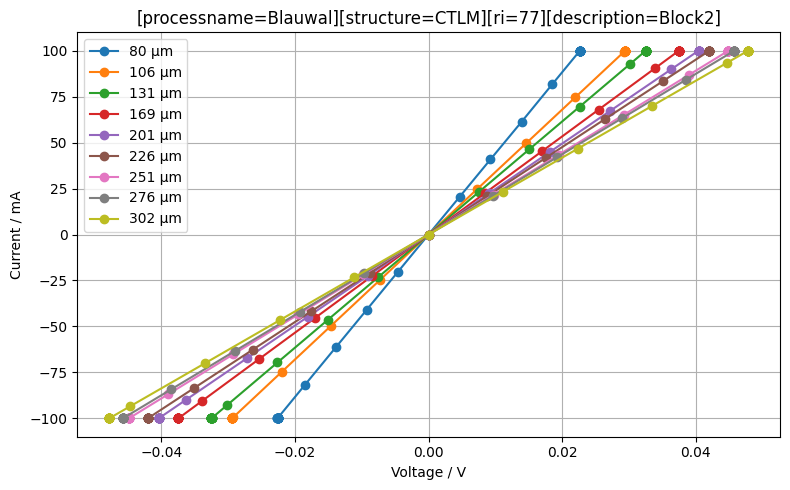

In [32]:
plt.figure(figsize=(8, 5))

for key in list_of_measurements.keys():
    # plt.plot(list_of_measurements[key]['Vin'], list_of_measurements[key]['Iin']*1000, label=key)
    plt.plot(list_of_measurements[key]['delta_V'], list_of_measurements[key]['Iin']*1000, 'o-', label=f"{key} µm")

plt.xlabel("Voltage / V")
plt.ylabel("Current / mA")
# plt.xlim(-0.5, 0.5)
plt.title(name)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig(os.path.join(folder_path, 'IV.png'), bbox_inches='tight')

In [5]:
def get_lin_fit(x, y):
    slope, intercept = np.polyfit(x, y, 1)
    y_fit = slope * x + intercept
    r_squared = 1- np.sum((y - y_fit)**2)/(np.sum((y - np.mean(y))**2)) # R^2 = 1 - SS_res / SS_tot = 1 - (y-y_fit)^2/(y-mean(y))^2

    return slope, intercept, r_squared

### check lineartiy of individual measuremnts

In [54]:
def plot_IV(key, plot_data):
    plt.figure(figsize=(8, 5))

    plt.plot(plot_data['delta_V'], plot_data['Iin']*1000, label=f"{key} µm")
    slope, intercept, r_squared = get_lin_fit(list_of_measurements[key]['delta_V'], list_of_measurements[key]['Iin'])
    plt.plot(plot_data['delta_V'], (slope * plot_data['delta_V'] + intercept)*1000, 'r--', label=f'linear fit: R² = {r_squared:.3f}')   # *1000 for mA

    plt.xlabel("Voltage / V")
    plt.ylabel("Current / mA")
    plt.title(name)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


keys = list(list_of_measurements.keys())
interact(
    lambda key: plot_IV(keys[key], plot_data=list_of_measurements[keys[key]]),
    key=widgets.IntSlider(min=0, max=len(keys)-1, value=0)
)

interactive(children=(IntSlider(value=0, description='key', max=8), Output()), _dom_classes=('widget-interact'…

<function __main__.<lambda>(key)>

### calcualte TLM values

In [118]:
R_list = []
R_corr_list = []
for key in list_of_measurements.keys():
    slope, intercept, r_squared = get_lin_fit(list_of_measurements[key]['delta_V'], list_of_measurements[key]['Iin'])
    print(slope)
    R_list.append((1/slope))  # in ohm
    corr_factor = (77 / key) * np.log((77 + key) / 77)
    R_corr_list.append((1/slope)* (1/corr_factor))  # in ohm
print(R_list)
print(R_corr_list)



4.418018251209201
3.397947635572418
3.075463107663604
2.668721797745279
2.4744052520757482
2.3785436370377266
2.2278019999059255
2.1848056882410782
2.0908032609196505
[np.float64(0.2263458281835532), np.float64(0.29429529446869773), np.float64(0.325154282458517), np.float64(0.37471121974754706), np.float64(0.40413751917197566), np.float64(0.42042533272394145), np.float64(0.44887292499164083), np.float64(0.45770660767780685), np.float64(0.47828507765008216)]
[np.float64(0.3300830529293764), np.float64(0.4679944551077326), np.float64(0.556673421266592), np.float64(0.708049626853244), np.float64(0.8217350729727165), np.float64(0.900759899110969), np.float64(1.0096611092197052), np.float64(1.0774617172927086), np.float64(1.177031505729205)]


### plot TLM

[ 80 106 131 169 201 226 251 276 302]


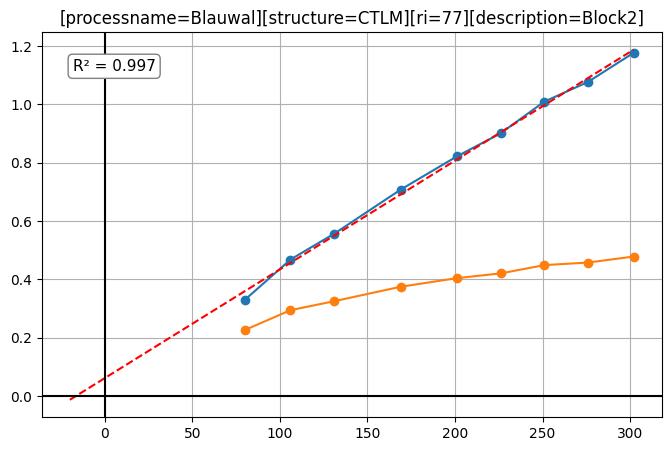

In [120]:
plt.figure(figsize=(8, 5))

distances = list(map(int, list_of_measurements.keys()))
distances = np.array(distances)
print(distances)
plt.plot(distances, R_corr_list, 'o-')
plt.plot(distances, R_list, 'o-')

slope, intercept, r_squared = get_lin_fit(distances, R_corr_list)
x_fit_extended = np.linspace(-20, distances.max(), 200)
plt.plot(x_fit_extended, (slope * x_fit_extended + intercept), 'r--', label='linear fit')

plt.gca().text(
    0.05, 0.9, f"R² = {r_squared:.3f}",
    fontsize=11,
    transform=plt.gca().transAxes,
    # verticalalignment='bottom',
    # horizontalalignment='right',
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray')    # alpha=0.8
)
plt.axhline(0, color='black', linewidth=1.5)
plt.axvline(0, color='black', linewidth=1.5)


plt.title(name)
# plt.xlim(0, max(list_of_measurements.keys())+20)
plt.grid(True)
plt.show()

### calculate cTLM values
$L_T$, $R_{sh}$, $R_C$

In [7]:
def get_ctlm_params(lengths, resistances):
    slope, intercept = np.polyfit(lengths, resistances, 1)
    LT = -intercept / slope
    Rsh = slope
    Rc = intercept / 2

    return LT, Rsh, Rc